# Alguns conceitos relevantes sobre treinamento:

* Sementes de geradores aleatórios
* Learning rate scheduler
* Aumento de dados

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

### Sementes de geradores aleatórios

Para o treinamento de redes é comum que seja necessário sortear valores aleatórios. Mas se cada execução de um programa levar a um resultado distinto, será difícil tornar o programa reprodutível e também depurar o código para identificar erros. Programas em Python costumam usar diferentes geradores aleatórios de diferentes bibliotecas. É boa prática utilizar uma semente para todos os geradores.



In [2]:
def seed_all(seed):
    # Seed do Pytorch
    torch.manual_seed(seed)
    # Seed do gerador do Python
    random.seed(seed) 
    # Seed do numpy
    np.random.seed(seed)

seed_all(0)

### Learning rate scheduler

A taxa de aprendizado é um dos parâmetros mais relevantes para o método gradiente descendente. No começo do treinamento queremos usar uma alta taxa de aprendizado para que os parâmetros evoluam rapidamente. Mas quando chegamos próximo a um mínimo da função de loss, uma alta taxa de aprendizado atrapalha a identificação do mínimo. Nesse caso, queremos utilizar uma taxa de aprendizado menor. Isso é feito definindo um *scheduler* que será responsável por reduzir a taxa de aprendizado durante o treinamento.

Primeiro, vamos relembrar como é um **loop típico de treinamento**:

In [3]:
num_epochs = 100
lr = 0.1

# Dataset artificial para ilustração
ds = torch.rand(10,2)
# Modelo de uma camada para ilustração
model = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
# Otimizador
optim = torch.optim.SGD(model.parameters(), lr=lr)
# Loop típico de treinamento
for epoch in range(num_epochs):
    for imgs, targets in ds:
        #Aplica o modelo no batch, calcula os gradientes
        #...
        # Atualiza os parâmetros: p -= lr*p.grad
        optim.step()

Vamos modificar esse loop para usar um scheduler. Existem vários schedulers disponíveis no Pytorch. Utilizaremos o PolynomialLR

In [4]:
from torch.optim import lr_scheduler

optim = torch.optim.SGD(model.parameters(), lr=lr)
sched = lr_scheduler.PolynomialLR(optim, total_iters=num_epochs, power=1.)

for epoch in range(num_epochs):
    for imgs, targets in ds:
        #Aplica o modelo no batch, calcula os gradientes
        #...
        # Atualiza os parâmetros: p -= lr*p.grad
        optim.step()
    # Altera o valor de lr
    sched.step()

Podemos visualizar como o scheduler está variando a taxa de aprendizado:

In [5]:
optim = torch.optim.SGD(model.parameters(), lr=lr)
sched = lr_scheduler.PolynomialLR(optim, total_iters=num_epochs, power=2)

lrs = [sched.get_last_lr()]
for _ in range(num_epochs):
    optim.step()
    sched.step()
    lrs.append(sched.get_last_lr())

plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('lr')

Text(0, 0.5, 'lr')

Error in callback <function _draw_all_if_interactive at 0x7f1647949080> (for post_execute), with arguments args (),kwargs {}:


ValueError: object __array__ method not producing an array

ImportError: cannot import name 'ERR_IGNORE' from 'numpy.core.umath' (/home/pgirardi/Desktop/Foundations-of-Computer-Vision/M06_classificacao_de_imagens_naturais/venv_vision/lib/python3.12/site-packages/numpy/core/umath.py)

<Figure size 640x480 with 1 Axes>

### Aumento de dados

Uma estratégia comum para evitar overfitting é realizar o aumento de dados. Existem inúmeras transformações que podem ser aplicadas para tornar os dados de treinamento mais variados. A biblioteca [albumentations](https://albumentations.ai/) é muito utilizada para essa finalidade. Mas utilizaremos as transformações que o Torchvision oferece. 

É importante salientar que as transformações do Torchvision passaram por uma reformulação recente. Então a API ainda está instável e um pouco confusa.

In [6]:
from PIL import Image
import torchvision.transforms.v2 as transf

def show_imgs(imgs):
    n = len(imgs)
    fig, axs = plt.subplots(1, n, figsize=(2*n,3))
    for img, ax in zip(imgs, axs):
        ax.imshow(img)

img = Image.open('../data/basset_hound_53.jpg')
# Equalização de histograma
eq_t = transf.RandomEqualize(p=1.)
img_eq = eq_t(img)
# Representação da imagem com 2 bits (3*4=12 cores)
pos_t = transf.RandomPosterize(bits=2, p=1.)
img_pos = pos_t(img)
# Aumenta a nitidez da imagem (realça bordas)
sharp_t = transf.RandomAdjustSharpness(sharpness_factor=10, p=1.)
img_sharp = sharp_t(img)
show_imgs([img, img_eq, img_pos, img_sharp])

Error in callback <function _draw_all_if_interactive at 0x7f1647949080> (for post_execute), with arguments args (),kwargs {}:


ValueError: object __array__ method not producing an array

ValueError: Output array must be a NumPy array

<Figure size 800x300 with 4 Axes>

O parâmetro `p` indica a probabilidade que a transformação será aplicada. 

In [7]:
# saturação: quão "vivas" são as cores
# hue: colorização da imagem (esverdeada, avermelhada, etc)
# brightness=0.5 possui o significado: será sorteado um valor entre [1-0.5, 1+0.5]
# esse valor será usado para aumentar (se >1) ou reduzir (se <1) o brilho da imagem
# O mesmo ocorre para os outros parâmetros
cj = transf.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2, hue=0.01)
imgs = []
for _ in range(5):
    imgs.append(cj(img))
show_imgs(imgs)

OverflowError: Python integer -2 out of bounds for uint8

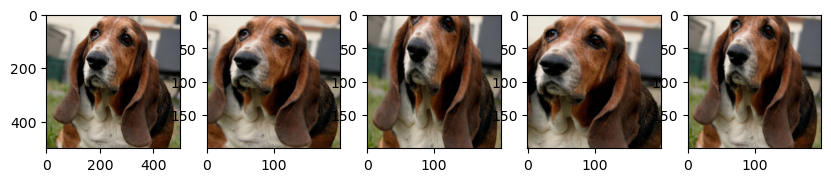

In [ ]:
# Gera uma região possuindo uma área no intervalo [0.5*A, A], onde A é a área
# da imagem. A área gerada terá uma razão de aspecto (divisão entre a largura
# e altura da imagem) entre [0.7,1.3]. A imagem é recortada (crop) na região 
# gerada. Após o recorte, a imagem é redimensionada para o tamanho (200,200)
rescrop = transf.RandomResizedCrop(size=(200,200), scale=(0.5,1.), ratio=(0.7,1.3))
imgs = [img]
for _ in range(4):
    imgs.append(rescrop(img))
show_imgs(imgs)

Unindo todas as transformações, temos

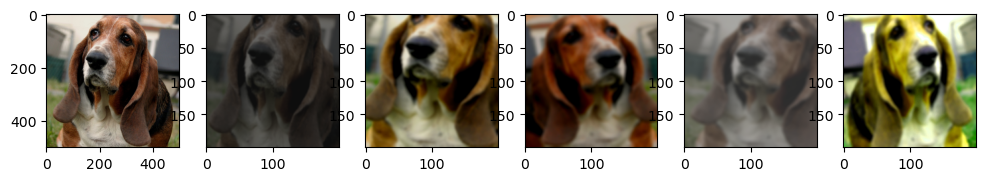

In [ ]:
transform = transf.Compose([
    #transf.PILToTensor(),   # Recomendado por questão de eficiência
    transf.RandomResizedCrop(size=(200,200), scale=(0.5,1.), ratio=(0.7,1.3)),
    transf.RandomHorizontalFlip(),
    transf.GaussianBlur(kernel_size=7, sigma=(0.5, 3.)),
    transf.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transf.RandomEqualize(p=0.1),
    transf.RandomPosterize(bits=8, p=0.1),
    transf.RandomAdjustSharpness(sharpness_factor=5, p=0.1),
    #transf.ToDtype(torch.float32),
    #transf.Normalize(mean=(128, 132, 142), std=(23, 43, 34)), # Removido para facilitar visualização
])
imgs = [img]
for _ in range(5):
    imgs.append(transform(img))
show_imgs(imgs)

O Pytorch também fornece uma classe que aplica o método AutoAugment, que sorteia transformações dentre um conjunto pré-definido e as aplica na imagem.

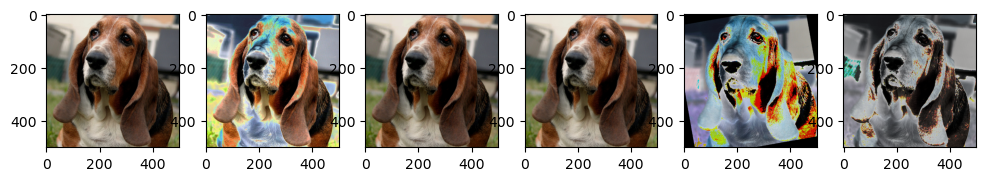

In [ ]:
auto = transf.AutoAugment()
imgs = [img]
for _ in range(5):
    imgs.append(auto(img))
show_imgs(imgs)

É preciso tomar cuidado com aumento de dados. Se as imagens geradas forem muito "irrealísticas", o aumento irá atrapalhar o treinamento.

Mas não importa a situação, é sempre útil pelo menos realizarmos *alguma* variação nas imagens durante o treinamento. Se a rede for aplicada sempre exatamente nos mesmos dados haverá grande chance de overfitting. Portanto é útil aplicar pelo menos uma leve alteração nos valores dos píxeis. De longe **a transformação mais comum é a RandomResizedCrop**. Ela é "segura", no sentido de não gerar imagens com valores espúrios, e o resize permite que os filtros da convolução sejam aplicados em píxeis distintos cada vez que a imagem é processada. 